In [1]:
import tensorflow as tf
import numpy as np
import random as rand

from collections import deque, Counter

import visualize_test as cube

import matplotlib.pyplot as plt

import os

In [2]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1

        return (self.tree[idx], self.data[data_idx])

In [4]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.8
    beta = 0.3
    beta_increment_per_sampling = 0.0005

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity

    def _get_priority(self, error):
        return (np.abs(error) + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = np.random.uniform(a, b)
            p, data = self.tree.get(s)
            priorities.append(p)
            batch.append(data)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)

In [5]:
class DQN_model(tf.keras.models.Model):
    def __init__(self, action_space):
        super().__init__()
        self.rescaling_layer = tf.keras.layers.Rescaling(1./6)

        self.conv_layer = tf.keras.layers.Conv3D(32, (2, 2, 2), activation='relu')
        self.pooling_layer = tf.keras.layers.MaxPool3D((2, 2, 2))

        self.flatten_layer = tf.keras.layers.Flatten()
        
        self.dense_layer0 = tf.keras.layers.Dense(32, activation='relu')
        
        self.value_layer = tf.keras.layers.Dense(1, activation='linear')
        self.advantage_layer = tf.keras.layers.Dense(action_space, activation='linear')

    def call(self, x):
        r = self.rescaling_layer(x)

        c = self.conv_layer(r)
        p = self.pooling_layer(c)

        f = self.flatten_layer(p)

        d = self.dense_layer0(f)

        v = self.value_layer(d)
        a = self.advantage_layer(d)

        avg_a = tf.math.reduce_mean(a, axis=1, keepdims=True)
        q = v + a - avg_a

        return q

In [6]:
class DQN_agent:
    def __init__(self, memory_size=100000, state_shape=[3, 3, 3, 6], action_space=18, batch_size=64):

        self.state_shape = state_shape
        self.state_shape.insert(0, batch_size)

        self.action_size = action_space
        self.batch_size = batch_size

        self.memory = Memory(memory_size)

        self.gamma = 0.995    # discount rate

        # EXPLORATION HYPERPARAMETERS for epsilon and epsilon greedy strategy
        self.epsilon = 1.0 # exploration probability at start
        self.epsilon_min = 0.001 # minimum exploration probability
        self.epsilon_decay = 0.000015 # exponential decay rate for exploration prob

        self.explore_probability = 0

        self.decay_step = 0

        self.tau = 1e-2 # target network soft update hyperparameter

        self.target_update_counter = 0
        self.target_update_interval = 100

        # create main model and target model
        try:
            self.train_model = tf.keras.models.load_model('./model')
            self.target_model = tf.keras.models.load_model('./model')

        except OSError:
            self.train_model = DQN_model(self.action_size)
            self.target_model = DQN_model(self.action_size)

            self.update_model()

        self.optim = tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-4)

    def update_model(self) -> None:
        self.target_model.set_weights(self.train_model.get_weights())

    def soft_update_model(self) -> None:
        train_weight = np.array(self.train_model.get_weights(), dtype=object)
        target_weight = np.array(self.target_model.get_weights(), dtype=object)

        weight = train_weight * self.tau + target_weight * (1 - self.tau)
        self.target_model.set_weights(weight)

    def memorize(self, state, action, reward, next_state, done) -> None:
        experience = state, action, reward, next_state, done
        td_error = reward + self.gamma * np.argmax(self.target_model(next_state)[0]) - np.argmax(self.train_model(state)[0])

        self.memory.add(td_error, experience)

    def convert_memory_to_input(self, batch):
        s, a, r, ns, d = zip(*batch)

        states = tf.convert_to_tensor(s).reshape(self.state_shape)
        action = tf.convert_to_tensor(a)
        rewards = tf.convert_to_tensor(r)
        next_states = tf.convert_to_tensor(ns).reshape(self.state_shape)
        dones = tf.convert_to_tensor(d)

        return states, action, rewards, next_states, dones

    def return_action_list(self, state):
        self.explore_probability = self.epsilon_min + (self.epsilon - self.epsilon_min) * np.exp(-self.epsilon_decay * self.decay_step)

        action_list = list(self.train_model(state)[0])
        return_array = []

        while len(return_array) < self.action_size:
            if self.explore_probability > np.random.random():
                action = np.random.randint(0, self.action_size)
                if any(action == i for i in return_array):
                    continue
                
            else:
                action = np.argmax(action_list)
                action_list[action] = 0

            return_array.append(action)
            
        return return_array

    def run(self):
        if self.memory.tree.total() < self.batch_size:
            return np.array([0])
        
        batch, _ = self.memory.sample(self.batch_size)

        try:
            states, actions, rewards, next_states, dones = self.convert_memory_to_input(batch)
        except TypeError:
            return np.array(0)

        loss = self.learn(states, actions, rewards, next_states, dones)

        return loss.numpy().mean()

    @tf.function
    def learn(self, states, actions, rewards, next_states, dones):
        target_q = rewards + (1 - dones) * self.gamma * tf.reduce_max(self.target_model(next_states), axis=1, keepdims=True)
        
        with tf.GradientTape() as tape:
            tape.watch(self.train_model.trainable_variables)

            q = self.train_model(states)

            onehot_actions = tf.one_hot(actions, self.action_size)
            val = tf.reduce_sum(onehot_actions * q, axis=1)

            loss = tf.keras.losses.mean_squared_error(target_q, val)

        grads = tape.gradient(loss, self.train_model.trainable_weights)
        self.optim.apply_gradients(zip(grads, self.train_model.trainable_weights))

        return loss

In [7]:
class Environment:
    def __init__(self, cube_name):
        self.cube_name = cube_name
        self.cube = cube.Cube(cube_name)
        self.action_list = ["R","R2","R'","U","U2","U'","F","F2","F'","L","L2","L'","D","D2","D'","B","B2","B'",]

        self.shuffle_num = 1
        self.max_depth = 20
        self.action_counter = 0
        self.reward_history = []

    def reset_env(self):
        self.cube = cube.Cube(self.cube_name)

        return self.shuffle_num

    def to_scramble(self, action):
        action = self.action_list[action]

        return action

    def shuffle(self, shuffle_num):
        scramble = self.cube.generate_scramble(shuffle_num)
        self.cube.execute(scramble)
        state = self.cube.get_state()

        return np.array([state], dtype=np.float32), scramble

    def step(self, act, action_num):
        turning_str = self.to_scramble(act)
        self.cube.execute(turning_str)

        next_state = self.cube.get_state()

        done = self.cube.solved()

        reward = int(done) * 10 * np.exp(self.shuffle_num - action_num)

        return np.array(reward, dtype=np.float32), np.array([next_state], dtype=np.float32), done, turning_str

    def depth_step(self, depth, state, action_list, human_actions):
        self.action_counter += 1
        
        if depth == self.max_depth:
            return False, human_actions[0:-1]

        for action in action_list[0:19-depth]:
            reward, next_state, done, human_action = self.step(action, depth)
            agent.memorize(state, action, reward, next_state, done)

            human_actions.append(human_action)
            self.reward_history.append(reward)

            if done:
                print(f"==={human_actions}===")
            #     return True, human_actions

            next_action_list = agent.return_action_list(next_state)
            is_end, human_actions = self.depth_step(depth+1, next_state, next_action_list, human_actions)

            self.cube.reverse_execute(human_action)

            # if is_end:
            #     return True, human_actions

        return False, human_actions[0:-1]

In [8]:
completed_capacity = 1000

agent = DQN_agent()
env = Environment("3x3x3")

retried = 0
success_que = deque(maxlen=100)
loss = 0

loss_history = []

e = 0

2023-11-28 19:53:33.926731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 19:53:33.928958: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
while True:
    shuffle_num = env.reset_env()
    state, scramble = env.shuffle(shuffle_num)
    env.max_depth = min(20, shuffle_num*2)

    action_list = agent.return_action_list(state)
    is_end, human_actions = env.depth_step(0, state, action_list, [])
    success_que.append(is_end)

    success = success_que.count(True)
    
    print(f"{shuffle_num} | {success} | {agent.explore_probability}")
    print(f"{scramble} / {env.action_counter}")
    print(f"{human_actions}-{is_end}")
    print("----------------------------------")

    if e % 10 == 0:
        loss = agent.run().mean()
        loss_history.append(loss)

    if e % 500 == 0:
        agent.soft_update_model()

    # if success == 100:
    #     env.shuffle_num += 1

    e += 1
    agent.decay_step += 1

===['D', 'D2']===
===['D2', 'D']===
===["D'"]===
1 | 0 | 1.0
D  / 343
[]-False
----------------------------------
===['F']===
===["F'", 'F2']===
===['F2', "F'"]===
1 | 0 | 0.999985015112387
F'  / 686
[]-False
----------------------------------
===['F2']===
===["F'", "F'"]===
===['F', 'F']===
1 | 0 | 0.9999700304495455
F2  / 1029
[]-False
----------------------------------
===["B'", "B'"]===
===['B', 'B']===
===['B2']===
1 | 0 | 0.9999550460114723
B2  / 1372
[]-False
----------------------------------
===['B2', 'B']===
===['B', 'B2']===
===["B'"]===
1 | 0 | 0.9999400617981641
B  / 1715
[]-False
----------------------------------
===["U'"]===
===['U2', 'U']===
===['U', 'U2']===
1 | 0 | 0.9999250778096173
U  / 2058
[]-False
----------------------------------
===['U']===
===["U'", 'U2']===
===['U2', "U'"]===
1 | 0 | 0.9999100940458286
U'  / 2401
[]-False
----------------------------------
===["D'", "D'"]===
===['D', 'D']===
===['D2']===
1 | 0 | 0.9998951105067947
D2  / 2744
[]-False
------

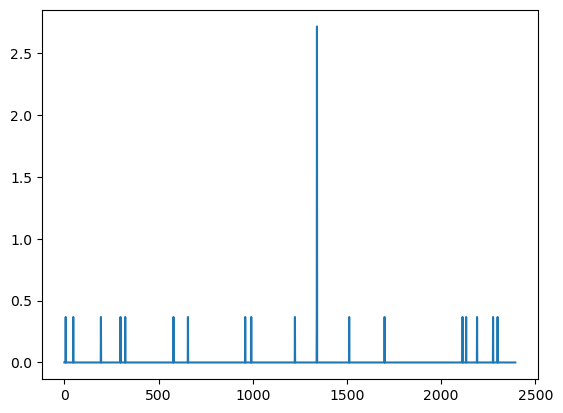

In [ ]:
plt.plot(env.reward_history)
plt.show()

In [ ]:
plt.plot(loss_history)
# plt.savefig('m.jpg')
plt.show()

In [ ]:
plt.plot(try_history)
plt.show()

In [ ]:
# np.savetxt('m.txt', np.array([max_count, e, shuffle_num, agent.explore_probability]))

In [ ]:
agent.train_model.save('model')